# Model with NEW Official Data (Marta's upload) & Incorporating Dummies by Regionname below

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, invgamma
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('NEW_OFFICIAL_cleaned_data_without_outliers.csv')
pd.DataFrame(data)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount,BuildingArea_missing
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067,...,1,1,202.0,120.320408,1950,-37.79960,144.99840,Northern Metropolitan,4019,1
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067,...,1,0,156.0,79.000000,1900,-37.80790,144.99340,Northern Metropolitan,4019,0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067,...,2,0,134.0,150.000000,1900,-37.80930,144.99440,Northern Metropolitan,4019,0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067,...,2,1,94.0,97.551020,1960,-37.79690,144.99690,Northern Metropolitan,4019,1
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067,...,1,2,120.0,142.000000,2014,-37.80720,144.99410,Northern Metropolitan,4019,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13143,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,2017-08-26,16.7,3150,...,2,2,652.0,212.029592,1981,-37.90562,145.16761,South-Eastern Metropolitan,7392,1
13144,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,2017-08-26,6.8,3016,...,2,2,333.0,133.000000,1995,-37.85927,144.87904,Western Metropolitan,6380,0
13145,Williamstown,83 Power St,3,h,1170000.0,S,Raine,2017-08-26,6.8,3016,...,2,4,436.0,165.510204,1997,-37.85274,144.88738,Western Metropolitan,6380,1
13146,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,2017-08-26,6.8,3016,...,1,5,866.0,157.000000,1920,-37.85908,144.89299,Western Metropolitan,6380,0


In [3]:
#Defining variables and splitting the dataset
#Features and target variable
X = data[['Rooms','Bathroom','Distance','Landsize']].values
y = np.log(data['Price'])

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [4]:
#Standardizing predictors
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
#Adding intercept to column X
X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print("Shape of X_train (with intercept):", X_train_scaled.shape)
print("Shape of X_test (with intercept):", X_test_scaled.shape)

Shape of X_train (with intercept): (10518, 5)
Shape of X_test (with intercept): (2630, 5)


In [6]:
#Predictive model
#Likelihood Function
def log_likelihood(y,X,beta,sigma2):
    n=len(y)
    mu=np.dot(X,beta) #Predicted mean
    residuals=y-mu
    return -0.5*n*np.log(2*np.pi*sigma2)-np.sum(residuals**2)/(2*sigma2)

#Priors
from scipy.stats import norm, invgamma

#Normal Prior for coefficients
def log_prior_beta(beta):
    return np.sum(norm.logpdf(beta,loc=0,scale=10)) #Mean=0, Var=10^2

#Inverse-Gamma prior for the variance
def log_prior_sigma2(sigma2):
    return invgamma.logpdf(sigma2,a=3,scale=10)

#Posterior
def log_posterior(y, X, beta, sigma2):
    return log_likelihood(y, X, beta, sigma2)+log_prior_beta(beta)+log_prior_sigma2(sigma2)

In [7]:
#MCMC Algorithm
def metropolis_hastings(y,X, iterations=1000, burn_in=100):
    n_params = X.shape[1]
    beta_samples = []
    sigma2_samples = []

    #Initialize parameters
    beta = np.zeros(n_params)
    sigma2 = 1

    accept_count = 0
    for sample in range(iterations):
        #Propose a new beta
        beta_proposal = beta + np.random.normal(0,0.03,size=n_params) # decreased the step size for beta (to improve acceptance rate)

        #Propose a new sigma2
        sigma2_proposal = sigma2 + np.random.normal(0,0.1) # decreased the step size for sigma2
        sigma2_proposal = abs(sigma2_proposal) #variance > 0

        #Calculate current and proposed posterior
        current_posterior = log_posterior(y, X, beta, sigma2)
        proposed_posterior = log_posterior(y,X, beta_proposal,sigma2_proposal)

        #Accept/reject step
        accept_ratio = np.exp(proposed_posterior-current_posterior)
        if np.random.rand() < accept_ratio:
            beta = beta_proposal
            sigma2 = sigma2_proposal

        #Store samples
        beta_samples.append(beta)
        sigma2_samples.append(sigma2)

        # Calculate acceptance ratio (added for monitoring)
        accept_ratio = np.exp(proposed_posterior - current_posterior)
        if np.random.rand() < accept_ratio:
            accept_count += 1

    # Convert lists to arrays
    beta_samples = np.array(beta_samples)
    sigma2_samples = np.array(sigma2_samples)

    # Apply burn-in
    beta_samples = beta_samples[burn_in:]
    sigma2_samples = sigma2_samples[burn_in:]

    print(f"Acceptance Rate: {accept_count / iterations:.2f}")


    return np.array(beta_samples), np.array(sigma2_samples)

In [8]:
#Running the model
# Apply log transformation to the target variable
beta_samples, sigma2_samples = metropolis_hastings(y_train,X_train_scaled,iterations=5000, burn_in=1000)

#Compute posterior means
beta_mean = np.mean(beta_samples, axis=0)
sigma2_mean = np.mean(sigma2_samples)

print("Posterior Mean of coefficients:",beta_mean)
print("Posterior Mean of Variance:",sigma2_mean)

/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_17255/2270533097.py:25: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior-current_posterior)
/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_17255/2270533097.py:35: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior - current_posterior)


Acceptance Rate: 0.19
Posterior Mean of coefficients: [13.45024993  0.22137779  0.08963931 -0.32364176  0.18751441]
Posterior Mean of Variance: 3.911997328406824


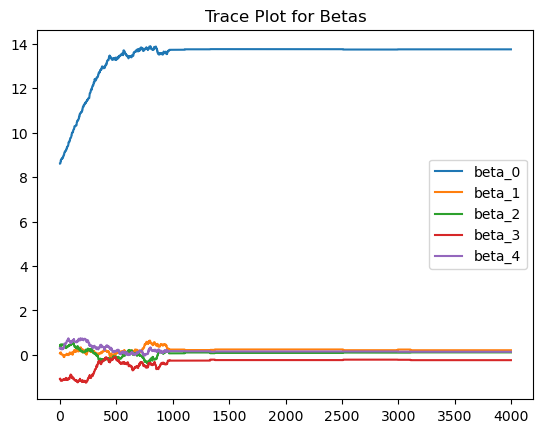

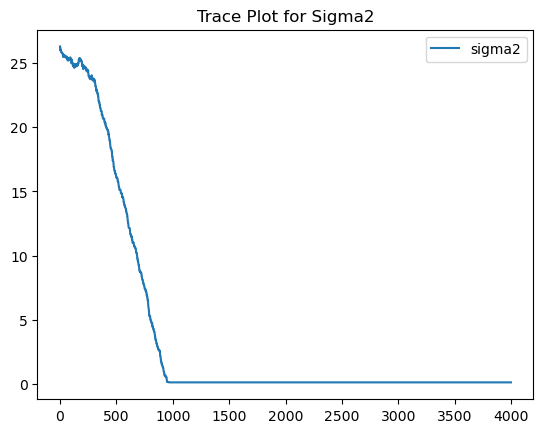

In [9]:
def plot_traces(beta_samples, sigma2_samples):
    # Plot beta traces
    for i in range(beta_samples.shape[1]):
        plt.plot(beta_samples[:, i], label=f'beta_{i}')
    plt.title("Trace Plot for Betas")
    plt.legend()
    plt.show()
    
    # Plot sigma2 trace
    plt.plot(sigma2_samples, label="sigma2")
    plt.title("Trace Plot for Sigma2")
    plt.legend()
    plt.show()

# Example usage
plot_traces(beta_samples, sigma2_samples)


In [10]:
#Checking for NaNs
print("Number of NaNs in y_test:", np.isnan(y_test).sum())
print("Number of NaNs in X_test:", np.isnan(X_test).sum())
print("Number of NaNs in y_train:", np.isnan(y_train).sum())
print("Number of NaNs in X_train:", np.isnan(X_train).sum())

Number of NaNs in y_test: 0
Number of NaNs in X_test: 0
Number of NaNs in y_train: 0
Number of NaNs in X_train: 0


In [11]:
#Checking dimensions
print("X_test_scaled shape:", X_test_scaled.shape)
print("beta_mean shape:", beta_mean.shape)
print("Shape of X_train:", X_train_scaled.shape)

X_test_scaled shape: (2630, 5)
beta_mean shape: (5,)
Shape of X_train: (10518, 5)


In [12]:
#Predicting price using the mean of posterior samples
y_pred_log = np.dot(X_test_scaled,beta_mean)
y_pred_price = np.exp(y_pred_log)

#Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(np.exp(y_test), y_pred_price)
mse = mean_squared_error(np.exp(y_test),y_pred_price)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 383433.4020725037
Mean Squared Error: 321706531988.2786


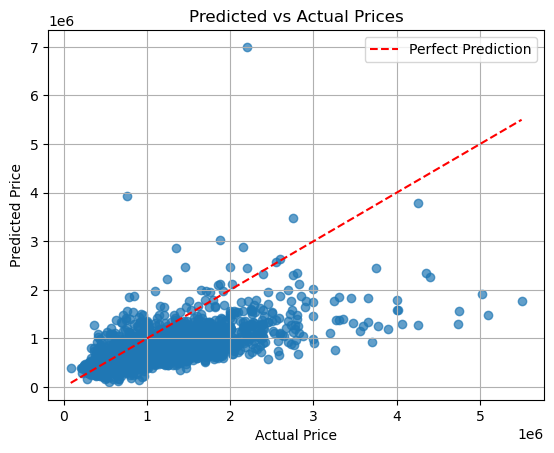

In [13]:
#Scatter plot of Predicted vs. Actual Values
plt.scatter(np.exp(y_test),y_pred_price,alpha=0.7)
plt.plot([min(np.exp(y_test)),max(np.exp(y_test))],[min(np.exp(y_test)),max(np.exp(y_test))],color='red',linestyle='--',label='Perfect Prediction')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid()
plt.show()

# Model with Regionname Dummies

### Creating dummies for each region (except 1 ofc)

In [14]:
#Checking how many unique region names there are
print(data['Regionname'].unique())

['Northern Metropolitan' 'Western Metropolitan' 'Southern Metropolitan'
 'Eastern Metropolitan' 'South-Eastern Metropolitan' 'Eastern Victoria'
 'Northern Victoria' 'Western Victoria']


In [15]:
#Creating dummies for each Region
data_encoded = pd.get_dummies(data, columns=['Regionname'],drop_first=True)
print(data_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13148 entries, 0 to 13147
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Suburb                                 13148 non-null  object 
 1   Address                                13148 non-null  object 
 2   Rooms                                  13148 non-null  int64  
 3   Type                                   13148 non-null  object 
 4   Price                                  13148 non-null  float64
 5   Method                                 13148 non-null  object 
 6   SellerG                                13148 non-null  object 
 7   Date                                   13148 non-null  object 
 8   Distance                               13148 non-null  float64
 9   Postcode                               13148 non-null  int64  
 10  Bedroom2                               13148 non-null  int64  
 11  Ba

Eastern Metropolitan is the left out dummy.

In [16]:
#Defining variables and splitting the dataset
#Features and target variable
X = data_encoded[['Rooms','Bathroom','Distance','Landsize','Regionname_Eastern Victoria',
          'Regionname_Northern Metropolitan','Regionname_Northern Victoria',
          'Regionname_South-Eastern Metropolitan','Regionname_Southern Metropolitan',
          'Regionname_Western Metropolitan','Regionname_Western Victoria']].values
y = np.log(data_encoded['Price'])

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [17]:
#Checking X
print("Shape of X:", X.shape)
print("First row of X:", X[0])

Shape of X: (13148, 11)
First row of X: [2 1 2.5 202.0 False True False False False False False]


In [18]:
#Fixing data type
X_test = X_test.astype(float)
X_train = X_train.astype(float)

In [19]:
#Standardizing predictors
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
#Adding intercept to column X
X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print("Shape of X_train (with intercept):", X_train_scaled.shape)
print("Shape of X_test (with intercept):", X_test_scaled.shape)

Shape of X_train (with intercept): (10518, 12)
Shape of X_test (with intercept): (2630, 12)


In [21]:
#Predictive model
#Likelihood Function
def log_likelihood(y,X,beta,sigma2):
    n=len(y)
    mu=np.dot(X,beta) #Predicted mean
    residuals=y-mu
    return -0.5*n*np.log(2*np.pi*sigma2)-np.sum(residuals**2)/(2*sigma2)

#Priors
from scipy.stats import norm, invgamma

#Normal Prior for coefficients
def log_prior_beta(beta):
    return np.sum(norm.logpdf(beta,loc=0,scale=10)) #Mean=0, Var=10^2

#Inverse-Gamma prior for the variance
def log_prior_sigma2(sigma2):
    return invgamma.logpdf(sigma2,a=2,scale=1)

#Posterior
def log_posterior(y, X, beta, sigma2):
    return log_likelihood(y, X, beta, sigma2)+log_prior_beta(beta)+log_prior_sigma2(sigma2)

In [22]:
#MCMC Algorithm
def metropolis_hastings(y,X, iterations=1000, burn_in=1000):
    n_params = X.shape[1]
    beta_samples = []
    sigma2_samples = []

    #Initialize parameters
    beta = np.zeros(n_params)
    sigma2 = 1

    accept_count = 0

    for sample in range(iterations):
        #Propose a new beta
        beta_proposal = beta + np.random.normal(0,0.03,size=n_params)

        #Propose a new sigma2
        sigma2_proposal = sigma2 + np.random.normal(0,0.05)
        sigma2_proposal = abs(sigma2_proposal) #variance > 0

        #Calculate current and proposed posterior
        current_posterior = log_posterior(y, X, beta, sigma2)
        proposed_posterior = log_posterior(y,X, beta_proposal,sigma2_proposal)

        #Accept/reject step
        accept_ratio = np.exp(proposed_posterior-current_posterior)
        if np.random.rand() < accept_ratio:
            beta = beta_proposal
            sigma2 = sigma2_proposal

        #Store samples
        beta_samples.append(beta)
        sigma2_samples.append(sigma2)

        # Calculate acceptance ratio (added for monitoring)
        accept_ratio = np.exp(proposed_posterior - current_posterior)
        if np.random.rand() < accept_ratio:
            accept_count += 1

    # Convert lists to arrays
    beta_samples = np.array(beta_samples)
    sigma2_samples = np.array(sigma2_samples)

    # Apply burn-in
    beta_samples = beta_samples[burn_in:]
    sigma2_samples = sigma2_samples[burn_in:]

    print(f"Acceptance Rate: {accept_count / iterations:.2f}")

    return np.array(beta_samples), np.array(sigma2_samples)

In [23]:
#Running the model
beta_samples, sigma2_samples = metropolis_hastings(y_train,X_train_scaled,iterations=5000, burn_in =1000)

#Compute posterior means
beta_mean = np.mean(beta_samples, axis=0)
sigma2_mean = np.mean(sigma2_samples)

print("Posterior Mean of coefficients:",beta_mean)
print("Posterior Mean of Variance:",sigma2_mean)

/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_17255/3352426876.py:26: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior-current_posterior)
/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_17255/3352426876.py:36: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior - current_posterior)


Acceptance Rate: 0.23
Posterior Mean of coefficients: [ 1.32388328e+01  2.32956634e-01  8.00605309e-02 -2.61477869e-01
  6.40432285e-02 -9.78598590e-03 -1.88206572e-01 -1.74766753e-02
  5.12699544e-02 -4.04913286e-02 -2.08478636e-01  4.03224004e-03]
Posterior Mean of Variance: 3.9503296431408494


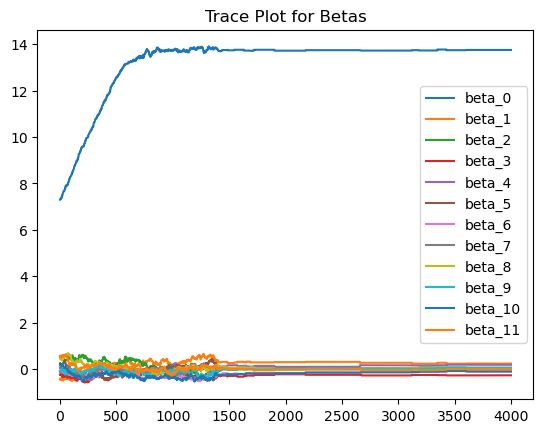

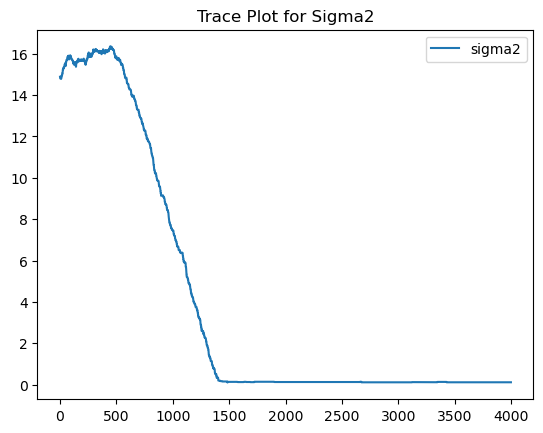

In [24]:
# Traceplots
def plot_traces(beta_samples, sigma2_samples):
    # Plot beta traces
    for i in range(beta_samples.shape[1]):
        plt.plot(beta_samples[:, i], label=f'beta_{i}')
    plt.title("Trace Plot for Betas")
    plt.legend()
    plt.show()
    
    # Plot sigma2 trace
    plt.plot(sigma2_samples, label="sigma2")
    plt.title("Trace Plot for Sigma2")
    plt.legend()
    plt.show()

# Example usage
plot_traces(beta_samples, sigma2_samples)


In [25]:
#Checking for NaNs
print("Number of NaNs in y_test:", np.isnan(y_test).sum())
print("Number of NaNs in X_test:", np.isnan(X_test).sum())
print("Number of NaNs in y_train:", np.isnan(y_train).sum())
print("Number of NaNs in X_train:", np.isnan(X_train).sum())

Number of NaNs in y_test: 0
Number of NaNs in X_test: 0
Number of NaNs in y_train: 0
Number of NaNs in X_train: 0


In [26]:
print("y_test dtype:", y_test.dtype)
print("X_test dtype:", X_test.dtype)
print("y_train dtype:", y_train.dtype)
print("X_train dtype:", X_train.dtype)

y_test dtype: float64
X_test dtype: float64
y_train dtype: float64
X_train dtype: float64


In [27]:
#Checking dimensions
print("X_test_scaled shape:", X_test_scaled.shape)
print("beta_mean shape:", beta_mean.shape)
print("Shape of X_train:", X_train_scaled.shape)

X_test_scaled shape: (2630, 12)
beta_mean shape: (12,)
Shape of X_train: (10518, 12)


In [28]:
#Predicting price using the mean of posterior samples
y_pred_log = np.dot(X_test_scaled,beta_mean)
y_pred_price = np.exp(y_pred_log)

#Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(np.exp(y_test), y_pred_price)
mse = mean_squared_error(np.exp(y_test),y_pred_price)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 483194.8824170612
Mean Squared Error: 433167033653.30096


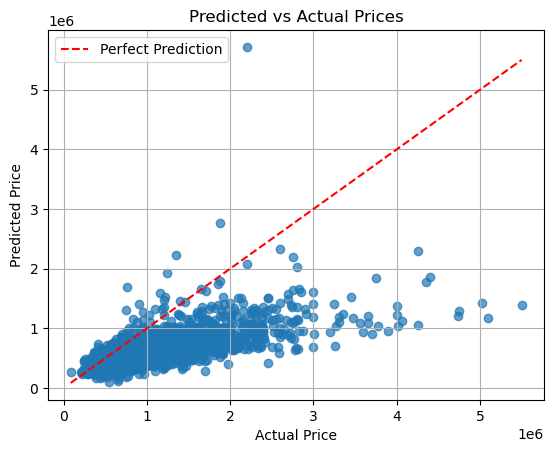

In [29]:
#Scatter plot of Predicted vs. Actual Values
plt.scatter(np.exp(y_test),y_pred_price,alpha=0.7)
plt.plot([min(np.exp(y_test)),max(np.exp(y_test))],[min(np.exp(y_test)),max(np.exp(y_test))],color='red',linestyle='--',label='Perfect Prediction')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid()
plt.show()

# Model with Regionname Dummies & Interactions (Marie's Try)

### Creating dummies for each region (except 1 ofc)

In [30]:
#Checking how many unique region names there are
print(data['Regionname'].unique())

['Northern Metropolitan' 'Western Metropolitan' 'Southern Metropolitan'
 'Eastern Metropolitan' 'South-Eastern Metropolitan' 'Eastern Victoria'
 'Northern Victoria' 'Western Victoria']


In [31]:
#Creating dummies for each Region
data_encoded = pd.get_dummies(data, columns=['Regionname'],drop_first=True)
print(data_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13148 entries, 0 to 13147
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Suburb                                 13148 non-null  object 
 1   Address                                13148 non-null  object 
 2   Rooms                                  13148 non-null  int64  
 3   Type                                   13148 non-null  object 
 4   Price                                  13148 non-null  float64
 5   Method                                 13148 non-null  object 
 6   SellerG                                13148 non-null  object 
 7   Date                                   13148 non-null  object 
 8   Distance                               13148 non-null  float64
 9   Postcode                               13148 non-null  int64  
 10  Bedroom2                               13148 non-null  int64  
 11  Ba

Eastern Metropolitan is the left out dummy.

In [32]:
# Create a copy of the relevant features
# Log-transform the 'Landsize' and 'Distance' features
data_encoded['log_Landsize'] = np.log(data_encoded['Landsize'] + 1)  # Add 1 to avoid log(0)
data_encoded['log_Distance'] = np.log(data_encoded['Distance'] + 1)

X = data_encoded[['Rooms', 'Bathroom', 'log_Distance', 'log_Landsize', 
                  'Regionname_Eastern Victoria',
                  'Regionname_Northern Metropolitan', 'Regionname_Northern Victoria',
                  'Regionname_South-Eastern Metropolitan', 'Regionname_Southern Metropolitan',
                  'Regionname_Western Metropolitan', 'Regionname_Western Victoria']].copy()

# Add interaction terms
X['Rooms_Bathroom'] = X['Rooms'] * X['Bathroom']  # Size-related interaction
X['Distance_Landsize'] = X['log_Distance'] * X['log_Landsize']  # Interaction capturing distance and land area

# Convert to numpy array
X = X.values

# Log-transform the target variable
y = np.log(data_encoded['Price'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
#Checking X
print("Shape of X:", X.shape)
print("First row of X:", X[0])

Shape of X: (13148, 13)
First row of X: [2 1 1.252762968495368 5.313205979041787 False True False False False
 False False 2 6.656187694531727]


In [34]:
#Fixing data type
X_test = X_test.astype(float)
X_train = X_train.astype(float)

In [35]:
#Standardizing predictors
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
#Adding intercept to column X
X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print("Shape of X_train (with intercept):", X_train_scaled.shape)
print("Shape of X_test (with intercept):", X_test_scaled.shape)

Shape of X_train (with intercept): (10518, 14)
Shape of X_test (with intercept): (2630, 14)


In [37]:
#Predictive model
#Likelihood Function
def log_likelihood(y,X,beta,sigma2):
    n=len(y)
    mu=np.dot(X,beta) #Predicted mean
    residuals=y-mu
    return -0.5*n*np.log(2*np.pi*sigma2)-np.sum(residuals**2)/(2*sigma2)

#Priors
from scipy.stats import norm, invgamma

#Normal Prior for coefficients
def log_prior_beta(beta):
    return np.sum(norm.logpdf(beta,loc=0,scale=20)) #Mean=0, Var=10^2 # Wider prior to allow more variability

#Inverse-Gamma prior for the variance
def log_prior_sigma2(sigma2):
    return invgamma.logpdf(sigma2,a=2,scale=1)

#Posterior
def log_posterior(y, X, beta, sigma2):
    return log_likelihood(y, X, beta, sigma2)+log_prior_beta(beta)+log_prior_sigma2(sigma2)

In [38]:
#MCMC Algorithm
def metropolis_hastings(y,X, iterations=1000, burn_in=1000):
    n_params = X.shape[1]
    beta_samples = []
    sigma2_samples = []

    #Initialize parameters
    beta = np.zeros(n_params)
    sigma2 = 1

    accept_count = 0

    for sample in range(iterations):
        #Propose a new beta
        beta_proposal = beta + np.random.normal(0,0.03,size=n_params)

        #Propose a new sigma2
        sigma2_proposal = sigma2 + np.random.normal(0,0.05)
        sigma2_proposal = abs(sigma2_proposal) #variance > 0

        #Calculate current and proposed posterior
        current_posterior = log_posterior(y, X, beta, sigma2)
        proposed_posterior = log_posterior(y,X, beta_proposal,sigma2_proposal)

        #Accept/reject step
        accept_ratio = np.exp(proposed_posterior-current_posterior)
        if np.random.rand() < accept_ratio:
            beta = beta_proposal
            sigma2 = sigma2_proposal

        #Store samples
        beta_samples.append(beta)
        sigma2_samples.append(sigma2)

        # Calculate acceptance ratio (added for monitoring)
        accept_ratio = np.exp(proposed_posterior - current_posterior)
        if np.random.rand() < accept_ratio:
            accept_count += 1

    # Convert lists to arrays
    beta_samples = np.array(beta_samples)
    sigma2_samples = np.array(sigma2_samples)

    # Apply burn-in
    beta_samples = beta_samples[burn_in:]
    sigma2_samples = sigma2_samples[burn_in:]

    print(f"Acceptance Rate: {accept_count / iterations:.2f}")

    return np.array(beta_samples), np.array(sigma2_samples)

In [39]:
#Running the model
beta_samples, sigma2_samples = metropolis_hastings(y_train,X_train_scaled,iterations = 5000, burn_in = 1000)

#Compute posterior means
beta_mean = np.mean(beta_samples, axis=0)
sigma2_mean = np.mean(sigma2_samples)

print("Posterior Mean of coefficients:",beta_mean)

print("Posterior Mean of Variance:",sigma2_mean)

/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_17255/3352426876.py:26: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior-current_posterior)
/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_17255/3352426876.py:36: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior - current_posterior)


Acceptance Rate: 0.21
Posterior Mean of coefficients: [ 1.33396051e+01  2.79131379e-01  1.60702029e-02  3.42176002e-01
  6.19102846e-01  7.10045810e-03 -6.14726334e-02 -1.74564507e-02
  9.18952251e-02  1.01365411e-01 -8.79930736e-02  3.02755978e-02
  1.14897716e-02 -9.01680285e-01]
Posterior Mean of Variance: 3.1282063665882323


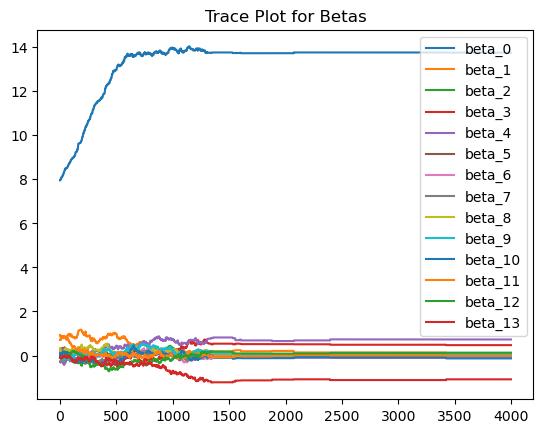

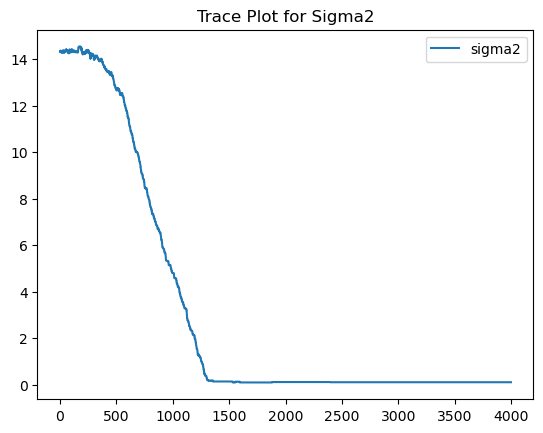

In [40]:
# Traceplots to assure convergence
def plot_traces(beta_samples, sigma2_samples):
    # Plot beta traces
    for i in range(beta_samples.shape[1]):
        plt.plot(beta_samples[:, i], label=f'beta_{i}')
    plt.title("Trace Plot for Betas")
    plt.legend()
    plt.show()
    
    # Plot sigma2 trace
    plt.plot(sigma2_samples, label="sigma2")
    plt.title("Trace Plot for Sigma2")
    plt.legend()
    plt.show()

# Example usage
plot_traces(beta_samples, sigma2_samples)


In [41]:
#Checking for NaNs
print("Number of NaNs in y_test:", np.isnan(y_test).sum())
print("Number of NaNs in X_test:", np.isnan(X_test).sum())
print("Number of NaNs in y_train:", np.isnan(y_train).sum())
print("Number of NaNs in X_train:", np.isnan(X_train).sum())

Number of NaNs in y_test: 0
Number of NaNs in X_test: 0
Number of NaNs in y_train: 0
Number of NaNs in X_train: 0


In [42]:
print("y_test dtype:", y_test.dtype)
print("X_test dtype:", X_test.dtype)
print("y_train dtype:", y_train.dtype)
print("X_train dtype:", X_train.dtype)

y_test dtype: float64
X_test dtype: float64
y_train dtype: float64
X_train dtype: float64


In [43]:
#Checking dimensions
print("X_test_scaled shape:", X_test_scaled.shape)
print("beta_mean shape:", beta_mean.shape)
print("Shape of X_train:", X_train_scaled.shape)

X_test_scaled shape: (2630, 14)
beta_mean shape: (14,)
Shape of X_train: (10518, 14)


In [44]:
#Predicting price using the mean of posterior samples
y_pred_log = np.dot(X_test_scaled,beta_mean)
y_pred_price = np.exp(y_pred_log)

#Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(np.exp(y_test), y_pred_price)
mse = mean_squared_error(np.exp(y_test),y_pred_price)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 417680.20186940837
Mean Squared Error: 325864867945.63904


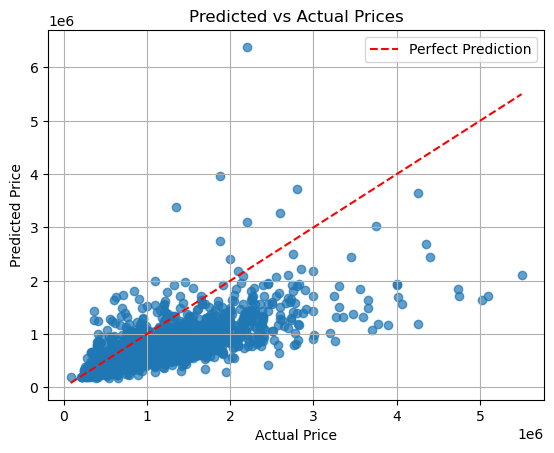

In [45]:
#Scatter plot of Predicted vs. Actual Values
plt.scatter(np.exp(y_test),y_pred_price,alpha=0.7)
plt.plot([min(np.exp(y_test)),max(np.exp(y_test))],[min(np.exp(y_test)),max(np.exp(y_test))],color='red',linestyle='--',label='Perfect Prediction')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid()
plt.show()

# Model with Gibbs-Sampling Algorithm

Posterior Mean of coefficients: [ 1.37494807e+01  3.13913047e-01  2.48371585e-01  1.86339794e-02
  3.96649712e-01 -3.83680014e-04 -1.01573075e-01 -1.43606869e-02
  1.77123272e-02  7.08023783e-02 -1.05093294e-01 -2.39290252e-02
 -2.61810960e-01 -4.10682425e-01]
Posterior Mean of Variance: 0.09606372003218018


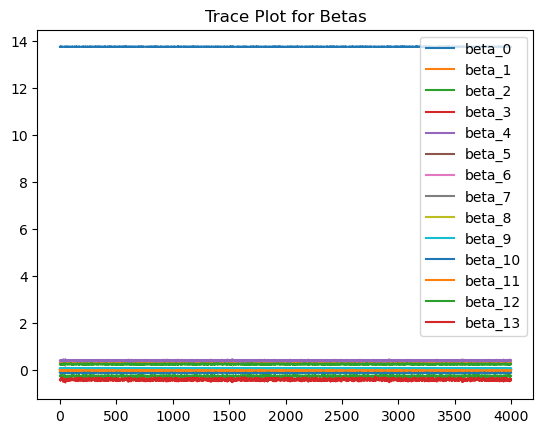

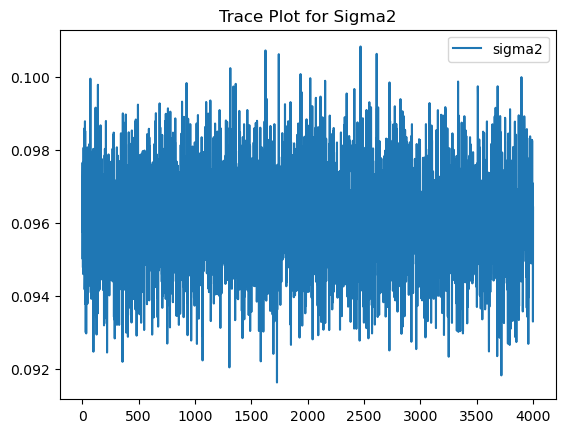

Mean Absolute Error: 250559.09438969634
Mean Squared Error: 147056566551.5979


In [46]:
# Gibbs Sampling Algorithm
def gibbs_sampling(y, X, iterations=5000, burn_in=1000):
    n, p = X.shape
    beta_samples = []
    sigma2_samples = []

    # Initialize parameters
    beta = np.zeros(p)
    sigma2 = 1

    # Hyperparameters for priors
    beta_prior_mean = np.zeros(p)
    beta_prior_variance = 20 ** 2  # Var = 20^2, as in the original prior
    alpha = 2  # Shape parameter for the inverse-gamma prior
    beta_scale = 1  # Scale parameter for the inverse-gamma prior

    for i in range(iterations):
        # Sample beta given sigma2
        beta_variance = np.linalg.inv((1 / beta_prior_variance) * np.eye(p) + (1 / sigma2) * np.dot(X.T, X))
        beta_mean = np.dot(beta_variance, np.dot(X.T, y) / sigma2)
        beta = np.random.multivariate_normal(beta_mean, beta_variance)

        # Sample sigma2 given beta
        residuals = y - np.dot(X, beta)
        alpha_post = alpha + n / 2
        beta_post = beta_scale + 0.5 * np.sum(residuals ** 2)
        sigma2 = 1 / np.random.gamma(alpha_post, 1 / beta_post)

        # Store samples
        beta_samples.append(beta)
        sigma2_samples.append(sigma2)

    # Convert lists to arrays
    beta_samples = np.array(beta_samples)
    sigma2_samples = np.array(sigma2_samples)

    # Apply burn-in
    beta_samples = beta_samples[burn_in:]
    sigma2_samples = sigma2_samples[burn_in:]

    return beta_samples, sigma2_samples

# Run Gibbs Sampling
beta_samples, sigma2_samples = gibbs_sampling(y_train, X_train_scaled, iterations=5000, burn_in=1000)

# Compute posterior means
beta_mean = np.mean(beta_samples, axis=0)
sigma2_mean = np.mean(sigma2_samples)

print("Posterior Mean of coefficients:", beta_mean)
print("Posterior Mean of Variance:", sigma2_mean)

# Traceplots to assure convergence
def plot_traces_gibbs(beta_samples, sigma2_samples):
    # Plot beta traces
    for i in range(beta_samples.shape[1]):
        plt.plot(beta_samples[:, i], label=f'beta_{i}')
    plt.title("Trace Plot for Betas")
    plt.legend()
    plt.show()
    
    # Plot sigma2 trace
    plt.plot(sigma2_samples, label="sigma2")
    plt.title("Trace Plot for Sigma2")
    plt.legend()
    plt.show()

# Example usage
plot_traces_gibbs(beta_samples, sigma2_samples)

# Predicting price using the mean of posterior samples
y_pred_log = np.dot(X_test_scaled, beta_mean)
y_pred_price = np.exp(y_pred_log)

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(np.exp(y_test), y_pred_price)
mse = mean_squared_error(np.exp(y_test), y_pred_price)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

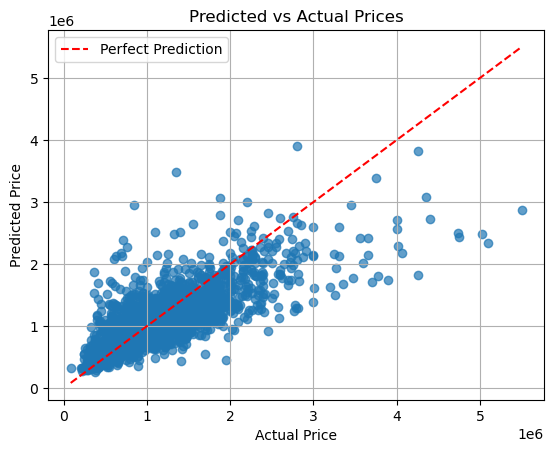

In [47]:
#Scatter plot of Predicted vs. Actual Values
plt.scatter(np.exp(y_test),y_pred_price,alpha=0.7)
plt.plot([min(np.exp(y_test)),max(np.exp(y_test))],[min(np.exp(y_test)),max(np.exp(y_test))],color='red',linestyle='--',label='Perfect Prediction')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid()
plt.show()